In [ ]:
import os
import random
import numpy as np
import cv2
import torch
from ultralytics import YOLO 

def resize_image(image, target_size=(800, 1000)):
  '''Resize the image while maintaining aspect ratio'''
  h, w = image.shape[:2]
  scale = min(target_size[1] / w, target_size[0] / h)
  new_w = int(w * scale)
  new_h = int(h * scale)
  resized_image = cv2.resize(image, (new_w, new_h))
  return resized_image

def logarithmic_transformation(image, epsilon=1e-5):
  '''Apply logarithmic transformation to the image with zero value handling'''
  c = 255 / np.log(1 + np.max(image))
  # Epsilon zero-handling technique
  log_image = c * (np.log(1 + image + epsilon))
  log_image = np.array(log_image, dtype=np.uint8)

  return log_image

def contrast_stretching(image):
  min_val = np.min(image)
  max_val = np.max(image)
  stretched = (image - min_val) * (255 / (max_val - min_val))
  return stretched.astype(np.uint8)

def gaussian_blur(image, mode='Soft'):
  if mode == 'Soft':
    kernel_size = (3,3)
  elif mode == 'Medium':
    kernel_size = (5,5)
  elif mode == 'Hard':
    kernel_size = (7,7)
  else:
    raise ValueError("Mode must be 'Soft', 'Medium', or 'Hard'")

  return cv2.GaussianBlur(image, kernel_size, 0)

def measure_blurriness(image):
  # Apply the Laplacian operator to detect edges
  laplacian = cv2.Laplacian(image, cv2.CV_64F)
  # Variance of Laplacian
  variance = laplacian.var()

  return variance

def adaptive_gaussian_blur(image, desired_blur=100, max_iterations=100):
  # Measure initial blur level
  initial_blur = measure_blurriness(image)

  # Set a starting kernel size
  kernel_size = 5

  for iteration in range(max_iterations):
      # Apply Gaussian blur with the current kernel size
      blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

      # Measure the blur after applying Gaussian blur
      current_blur = measure_blurriness(blurred_image)

      # If the current blur exceeds the desired blur, stop
      if current_blur > desired_blur:
          kernel_size += 2
      else:
        break

  final_blurred_img = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
  final_blur = measure_blurriness(final_blurred_img)

  print(f"Initial Blur: {initial_blur}, Final Blur: {final_blur}, Kernel Size: {kernel_size}, Iterations: {iteration+1}")

  return final_blurred_img

def clahe_equalization(image):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  equalized_img = clahe.apply(image)
  return equalized_img

def otsu_thresholding(image):
  _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  return binary_image

def canny_edge_detection(image, low_threshold=50, high_threshold=150):
  return cv2.Canny(image, low_threshold, high_threshold)

def find_extreme_corners(contours):
  '''Find the extreme corners of the image'''
  all_points = np.vstack(contours)
  top_left = all_points[np.argmin(all_points[:, :, 0] + all_points[:, :, 1])]
  bottom_right = all_points[np.argmax(all_points[:, :, 0] + all_points[:, :, 1])]
  top_right = all_points[np.argmax(all_points[:, :, 0] - all_points[:, :, 1])]
  bottom_left = all_points[np.argmin(all_points[:, :, 0] - all_points[:, :, 1])]
  return top_left[0], top_right[0], bottom_left[0], bottom_right[0]

def apply_perspective_transformation(image, corners):
  '''Apply perspective transformation to the image'''
  tl, tr, bl, br = corners
  width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
  height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

  dst_pts = np.array([
      [0, 0],
      [width - 1, 0],
      [0, height - 1],
      [width - 1, height - 1]
  ], dtype="float32")

  src_pts = np.array([tl, tr, bl, br], dtype="float32")

  M = cv2.getPerspectiveTransform(src_pts, dst_pts)
  warped = cv2.warpPerspective(image, M, (width, height))
  return warped

def automatic_warp_transformation(image, target_size=(800, 1000)):
  '''Automatic Cropping using Adaptive Warp Transformation'''
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  resized_image = resize_image(gray_image, target_size)
  brightened_image = logarithmic_transformation(resized_image)
  contrast_image = contrast_stretching(brightened_image)
  blurred_image = gaussian_blur(contrast_image, mode='Soft')
  binary_image = otsu_thresholding(blurred_image)
  edges = canny_edge_detection(binary_image)
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Getting Contours (Drawing Contours in image, useful for debugging)
  contour_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

  corners = find_extreme_corners(contours)
  for corner in corners:
      cv2.circle(contour_image, tuple(corner), 5, (0, 0, 255), -1)

  warped_image = apply_perspective_transformation(resized_image, corners)
  print(f'Initial image {image.shape} processed to {warped_image.shape}')

  return warped_image

def automatic_warp_transformation_v2(image, target_size=(800, 1000)):
  '''Automatic Cropping using Adaptive Warp Transformation'''
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  resized_image = resize_image(gray_image, target_size)
  
  clahe = clahe_equalization(resized_image)
  log_img = logarithmic_transformation(clahe)
  contrast_img = contrast_stretching(log_img)
  blurred_img = gaussian_blur(contrast_img)
  binary_img = otsu_thresholding(blurred_img)
  edges = canny_edge_detection(binary_img)
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Getting Contours (Drawing Contours in image, useful for debugging)
  contour_image = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

  corners = find_extreme_corners(contours)
  for corner in corners:
      cv2.circle(contour_image, tuple(corner), 5, (0, 0, 255), -1)

  warped_image = apply_perspective_transformation(resized_image, corners)
  print(f'Initial image {image.shape} processed to {warped_image.shape}')

  return warped_image

def image_uniformization(master_image, student_image):
  '''Precision Image Resizing'''
  master_shape = master_image.shape
  student_shape = student_image.shape

  master_height = master_shape[0]
  master_width = master_shape[1]

  student_height = student_shape[0]
  student_width = student_shape[1]

  min_height = min(master_height, student_height)
  min_width = min(master_width, student_width)

  resized_master = cv2.resize(master_image, (min_width, min_height))
  resized_student = cv2.resize(student_image, (min_width, min_height))

  print(f'master_key {master_image.shape} and student_answer {student_image.shape} uniformed to {resized_master.shape}')

  return resized_master, resized_student

def morph_open(image):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  eroded_img = cv2.erode(image, kernel, iterations = 1)
  dilated_img = cv2.dilate(eroded_img, kernel, iterations = 1)

  return dilated_img

def core_preprocessing(image):
  '''Core Preprocessing Module'''
  blurred_img = gaussian_blur(image, mode='Hard')
  contrast_img = contrast_stretching(blurred_img)
  log_img = logarithmic_transformation(contrast_img)
  binary_img = otsu_thresholding(log_img)
  opened_img = morph_open(binary_img)

  return opened_img

def core_preprocessing_v2(image):
  '''
  Core Preprocessing Module V2:
  - Uses CLAHE for lighting handling
  - Uses Adaptive Gaussian Blur to ensure optimal thresholding
  '''
  clahe_img = clahe_equalization(image)
  blurred_img = adaptive_gaussian_blur(clahe_img, desired_blur=100, max_iterations=100)
  contrast_img = contrast_stretching(blurred_img)
  log_img = logarithmic_transformation(contrast_img)
  binary_img = otsu_thresholding(log_img)
  opened_img = morph_open(binary_img)

  return opened_img

def draw_full_contours(contours, cont_image, radius = 7):
  '''Draw Full Circles'''
  for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      # Draw a filled circle at the center of the contour
      cv2.circle(cont_image, (cX, cY), radius, (0, 255, 0), -1)

  return cont_image

def extract_and_draw_contours(image):
  contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  unique_values = []
  for columns in image:
    for pixel in columns:
      if pixel not in unique_values:
        unique_values.append(pixel)

  contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  contour_image = draw_full_contours(contours, contour_image)

  return contours, contour_image

def extract_and_draw_circle_contours(image):
  contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  circle_contours = []
  contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

  # radius_list = []
  # contour_ar_list = []

  for contour in contours:
      # Approximate the enclosing circle for each contour
      (x, y), radius = cv2.minEnclosingCircle(contour)
      circle_area = np.pi * (radius ** 2)

      # if radius not in radius_list:
      #   radius_list.append(radius)

      # if contour_area not in contour_ar_list:
      #   contour_ar_list.append(contour_area)

      # Calculate the actual contour area
      contour_area = cv2.contourArea(contour)

      # Check if the contour area is approximately equal to the circle area
      # Tolerance range for being "circular"
      if radius < 5:
          if 0.6 <= contour_area / circle_area <= 1.4:
              circle_contours.append(contour)
      else:
          if 0.8 <= contour_area / circle_area <= 1.2:
              circle_contours.append(contour)

  # contour_image = cv2.drawContours(contour_image, circle_contours, -1, (0, 255, 0), thickness=2)
  contour_image = draw_full_contours(circle_contours, contour_image)

  return circle_contours, contour_image

def soft_morph_open(image):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  eroded_img = cv2.erode(image, kernel, iterations = 1)
  dilated_img = cv2.dilate(eroded_img, kernel, iterations = 1)

  return dilated_img

# ----------------------
def yolo_catch_image(model, image): 
    input = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    res = model.predict(input)
    pred = res[0]
    boxes = pred.boxes  
    coords = boxes.xywh  
    confidences = boxes.conf  
    class_ids = boxes.cls  
    
    return pred, boxes, coords

def get_max_width_height(master_coords, student_coords):
    """
    Computes the maximum width and height from master and student bounding box coordinates.

    Args:
        master_coords (torch.Tensor or numpy.ndarray): Bounding box coordinates for the master image (center_x, center_y, width, height).
        student_coords (torch.Tensor or numpy.ndarray): Bounding box coordinates for the student image (center_x, center_y, width, height).

    Returns:
        tuple: Maximum width and maximum height across both sets of coordinates.
    """
    max_width = 0
    max_height = 0

    # Combine both sets of coordinates
    all_coords = torch.cat([master_coords, student_coords], dim=0) if isinstance(master_coords, torch.Tensor) else np.vstack((master_coords, student_coords))
    
    # Traverse all bounding box dimensions
    for coord in all_coords:
        # Convert tensor to NumPy array if needed
        if isinstance(coord, torch.Tensor):
            coord = coord.cpu().numpy()
        _, _, width, height = coord.astype(int)
        
        # Update maximum width and height
        max_width = max(max_width, width)
        max_height = max(max_height, height)

    # return max(max_width, max_height)
    return int((max_width + max_height) / 2)

def mark_ans_box(image, coords, shape="box", size=10, color=(0, 255, 0), thickness=-1):
    """
    Draw a fixed-size filled box or circle at the center of each detected box.

    Args:
        image (numpy.ndarray): The input image where the shapes will be drawn.
        boxes (object): The detected boxes (used for validation, if needed).
        coords (torch.Tensor or numpy.ndarray): Box coordinates (center x, center y, width, height).
        shape (str): The shape to draw ("box" or "circle"). Default is "box".
        size (int): The size (side length or radius) of the shape. Default is 10.
        color (tuple): The color of the shape in (B, G, R). Default is green.
        thickness (int): Thickness of the shape. Use -1 for filled shapes. Default is -1.

    Returns:
        numpy.ndarray: The image with the shapes drawn on it.
    """
    input_img = image.copy()
    # input_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB)

    for coord in coords:
        # Convert tensor to NumPy array if needed and cast to integers
        if isinstance(coord, torch.Tensor):
            coord = coord.cpu().numpy()
        center_x, center_y, _, _ = coord.astype(int)

        if shape == "box":
            # Calculate the top-left and bottom-right coordinates of the box
            top_left = (center_x - size // 2, center_y - size // 2)
            bottom_right = (center_x + size // 2, center_y + size // 2)
            # Draw the box
            cv2.rectangle(input_img, top_left, bottom_right, color, thickness)
        elif shape == "circle":
            # Draw the circle
            cv2.circle(input_img, (center_x, center_y), size, color, thickness)
        else:
            raise ValueError("Shape must be either 'box' or 'circle'.")

    return input_img

def draw_filled_boxes(contours, cont_image):
    """
    Draws filled boxes inside each white region in a binary image.

    Args:
        image (numpy.ndarray): Grayscale input image with white regions on a black background.

    Returns:
        numpy.ndarray: Image with filled boxes drawn inside each white region.
    """
    
    input_img = cont_image.copy()
    input_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB)
    for contour in contours:
        # Get the bounding rectangle for each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate the center of the rectangle
        center_x, center_y = x + w // 2, y + h // 2
        
        # Define the size of the filled box
        size = min(w, h) // 2  # Adjust box size to fit within the region
        
        # Draw a filled rectangle centered within the bounding box
        top_left = (center_x - size, center_y - size)
        bottom_right = (center_x + size, center_y + size)
        cv2.rectangle(input_img, top_left, bottom_right, (0, 255, 0), -1)  

    return input_img

def draw_filled_boxes_fetch_contours(image):
    """
    Draws filled boxes inside each white region in a binary image.

    Args:
        image (numpy.ndarray): Grayscale input image with white regions on a black background.

    Returns:
        numpy.ndarray: Image with filled boxes drawn inside each white region.
    """
    # Convert to binary if not already
    # _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    
    input_img = image.copy()
    
    # Find contours
    contours, _ = cv2.findContours(input_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Convert to color for drawing
    result_image = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)
    
    for contour in contours:
        # Get the bounding rectangle for each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate the center of the rectangle
        center_x, center_y = x + w // 2, y + h // 2
        
        # Define the size of the filled box
        size = min(w, h) // 2  # Adjust box size to fit within the region
        
        # Draw a filled rectangle centered within the bounding box
        top_left = (center_x - size, center_y - size)
        bottom_right = (center_x + size, center_y + size)
        cv2.rectangle(result_image, top_left, bottom_right, (0, 255, 0), -1)  # Green filled box

    return contours, result_image

def draw_box_fill_space_overlap(master_contours, student_contours, image_shape, overlap_threshold=0.1):
    """
    Draws contours with conditions:
    - Regions with >=10% overlap between student and master contours are filled green.
    - Non-overlapping or <10% overlap contours from student_contours are left white.

    Args:
        master_contours (list): Contours from the master (reference) image.
        student_contours (list): Contours from the student (target) image.
        image_shape (tuple): Shape of the new image (height, width, channels).
        overlap_threshold (float): Minimum overlap ratio to classify as overlapping (default: 10%).

    Returns:
        numpy.ndarray: Image with processed contours.
    """
    # Create a blank image for the result
    result_img = np.zeros(image_shape, dtype=np.uint8)

    # Create masks for master and student contours
    master_mask = np.zeros(image_shape[:2], dtype=np.uint8)
    # student_mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Draw the master contours on the master mask
    cv2.drawContours(master_mask, master_contours, -1, 255, thickness=cv2.FILLED)

    for contour in student_contours:
        # Create an individual mask for the current student contour
        single_student_mask = np.zeros(image_shape[:2], dtype=np.uint8)
        cv2.drawContours(single_student_mask, [contour], -1, 255, thickness=cv2.FILLED)

        # Find overlapping regions using bitwise AND
        overlap_mask = cv2.bitwise_and(master_mask, single_student_mask)

        # Calculate the overlap ratio
        overlap_area = np.sum(overlap_mask > 0)
        student_area = np.sum(single_student_mask > 0)
        overlap_ratio = overlap_area / student_area if student_area > 0 else 0

        # Decide color based on overlap percentage
        if overlap_ratio >= overlap_threshold:
            # Fill green for significant overlap
            result_img[overlap_mask > 0] = (0, 255, 0)
        else:
            # Fill white for non-overlapping or low-overlap regions
            result_img[single_student_mask > 0] = (255, 255, 255)

    return result_img


def get_cross_answers(model, master_image, student_image): 
    master_pred, master_box, master_coords = yolo_catch_image(model, master_image)
    student_pred, student_box, student_coords = yolo_catch_image(model, student_image)
    
    box_size = get_max_width_height(master_coords, student_coords)
    
    master_img = mark_ans_box(master_image, master_coords, shape='box', size=box_size, color=(0, 255, 0), thickness=-1)
    student_img = mark_ans_box(student_image, student_coords, shape='box', size=box_size, color=(0, 255, 0), thickness=-1)
    
    return master_img, student_img

def box_contour_handling(master_image, student_image):
    master_contours, master_output = draw_filled_boxes_fetch_contours(master_image)
    student_contours, student_output = draw_filled_boxes_fetch_contours(student_image)
    
    shape = (student_image.shape[0], student_image.shape[1], 3)
    stu_mistake_loc_cont_img = draw_box_fill_space_overlap(master_contours, student_contours, shape)
    stu_mistake_loc_cont_img = cv2.cvtColor(stu_mistake_loc_cont_img, cv2.COLOR_BGR2GRAY)
    _, result_img = cv2.threshold(stu_mistake_loc_cont_img, 254, 255, cv2.THRESH_BINARY)
    stu_mistake_loc_final = soft_morph_open(result_img)
    
    return master_contours, student_contours, stu_mistake_loc_final

def final_scoring_cross(student_img, master_contours, student_mistake_loc): 
    mistake_contours, _ = draw_filled_boxes_fetch_contours(student_mistake_loc)
    
    student_correction = student_img.copy()
    student_correction = draw_filled_boxes(master_contours, student_correction)
    
    mistakes = len(mistake_contours)
    total_questions = len(master_contours)
    final_score = ((total_questions - mistakes) / total_questions) * 100
    final_score = round(final_score, 2)
    print(f'total_questions: {total_questions}, mistakes: {mistakes}')
    print(f'final score: {final_score}')
    
    return final_score, student_correction

In [24]:
import matplotlib.pyplot as plt

model = YOLO("C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/model/yolo/best.pt")

answer1 = cv2.imread('C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/inputs/cross/student2.jpg')
master_sheet = cv2.imread('C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/inputs/cross/master2.jpg')

In [30]:
student1 = automatic_warp_transformation_v2(answer1)
master_key = automatic_warp_transformation_v2(master_sheet)
new_master, new_student = image_uniformization(master_key, student1)

# plt.figure(figsize = (15, 10))

# plt.subplot(1, 2, 1)
# plt.imshow(new_master, cmap='gray')
# plt.title('Master Key')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(new_student, cmap='gray')
# plt.title('Student Answer')
# plt.axis('off')

# plt.show()

Initial image (1305, 2563, 3) processed to (488, 906)
Initial image (1405, 2767, 3) processed to (479, 894)
master_key (479, 894) and student_answer (488, 906) uniformed to (479, 894)



0: 352x640 45 xs, 251.3ms
Speed: 41.4ms preprocess, 251.3ms inference, 28.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 45 xs, 53.6ms
Speed: 2.0ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


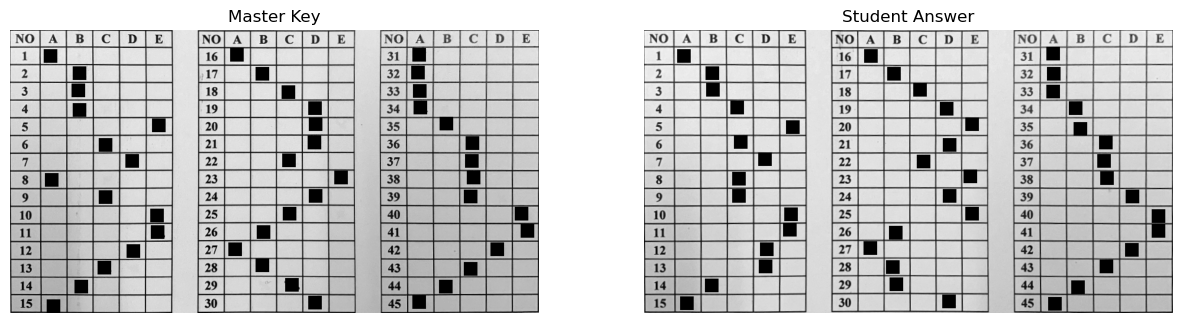

In [31]:
master_box_img, student_box_img = get_cross_answers(model, new_master, new_student)

plt.figure(figsize = (15, 10))

plt.subplot(1, 2, 1)
plt.imshow(master_box_img, cmap='gray')
plt.title('Master Key')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(student_box_img, cmap='gray')
plt.title('Student Answer')
plt.axis('off')

plt.show()

In [27]:
processed_master = core_preprocessing_v2(master_box_img)
processed_student = core_preprocessing_v2(student_box_img)

# plt.figure(figsize = (15, 10))

# plt.subplot(1, 2, 1)
# plt.imshow(processed_master, cmap='gray')
# plt.title('Master Key')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(processed_student, cmap='gray')
# plt.title('Student Answer')
# plt.axis('off')

# plt.show()

Initial Blur: 3860.5569847023316, Final Blur: 73.67991734316864, Kernel Size: 9, Iterations: 3
Initial Blur: 2868.2249749690777, Final Blur: 74.44981642952978, Kernel Size: 9, Iterations: 3


In [28]:
master_contours, student_contours, student_mistake_location = box_contour_handling(processed_master, processed_student)

print(len(master_contours))
print(len(student_contours))

# plt.figure(figsize = (15, 10))

# plt.subplot(1, 2, 1)
# plt.imshow(student_mistake_location, cmap='gray')
# plt.title('Student Mistake Location')
# plt.axis('off')

# plt.show()

45
45


In [29]:
final_score, student_correction = final_scoring_cross(new_student, master_contours, student_mistake_location)

cv2.imshow("student's answer vs master key: ", student_correction)
cv2.waitKey(0)
cv2.destroyAllWindows()

total_questions: 45, mistakes: 8
final score: 82.22
